In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from pandas import DataFrame

import mglearn

# generate 2d classification dataset
X, y = make_blobs(centers=4, random_state=8)

y = y % 2
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

<Figure size 640x480 with 1 Axes>

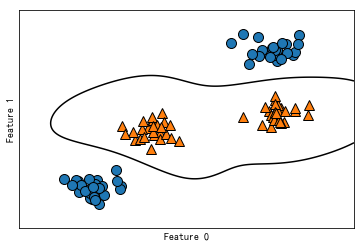

In [2]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

mglearn.plots.plot_2d_separator(svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

In [3]:
y.shape

(100,)

In [4]:
# 加载音频文件
from scipy.io import wavfile
def LoadWav(audio_file):
    sample_rate, signal = wavfile.read(audio_file)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))
    return sample_rate, signal

In [5]:
sample_rate, signal = LoadWav("0016.wav")

sample_rate:48000, len:12241920


In [6]:
import numpy as np

# 获取 MAN 文件
def GenerateManSeq(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    manSeq = [0] * slotCnt
    stotal = (FRAME_RATE / BASE_RATE) * slotCnt

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second

        # round to an even number
        pos = round(stime / stotal * slotCnt)

        if 0 <= pos and pos < slotCnt:
            manSeq[pos] = HIGH_VALUE
    return np.array(manSeq)

In [7]:
manSeq = GenerateManSeq(len(signal) // 240, "0016.man", 240, sample_rate, 1)

In [8]:
# 生成编号
preSeq = manSeq.copy()
for i in range(1, len(preSeq)):
    preSeq[i] += preSeq[i - 1]

In [9]:
preSeq = preSeq[:51006]

In [10]:
# 生成 onehot 编码
def GetOneHot(preSeq):
    
    col_cnt = preSeq.max() + 1
    oneHot = np.zeros((len(preSeq), col_cnt))
    
    # 计算 oneHot
    for i in range(len(preSeq)):
        oneHot[i][preSeq[i]] = 1
    return oneHot

In [11]:
oneHot = GetOneHot(preSeq)

In [12]:
import numpy as np
# np.set_printoptions(threshold=np.inf)

import pylab as pl
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.io import wavfile
# download opensouce audio in
# http://www.voiptroubleshooter.com/open_speech/american.html
def mfcc(sample_rate, signal):
    # 一、预处理(Preprocess)
    # 加载模型(load audio)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))

    # signal = signal[: int(3.5 * sample_rate)]  # read first 3.5s data for example.

    # n_frames = len(signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, signal)
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Original audio')
    # pl.show()

    # 预加重(Pre-Emphasis)
    # y(t) = x(t) - a * x(t - 1)
    pre_emphasis = 0.97  # usually 0.95 or 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[: -1]
    )

    # n_frames = len(emphasized_signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, emphasized_signal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Pre-Emphasis')
    # pl.show()

    # 分帧(Framing)
    # here, params set as follows:
    # frame_size = 0.025(s), it menas 8kHz signal has 0.025 * 8000 = 200 samples.
    # frame_stride = 0.01(s), 0.01 * 8000 = 80 samples.
    # overlap = 0.015(s), 0.015 * 8000 = 125 samples.
    frame_size, frame_stride, overlap = 0.025, 0.01, 0.015  # Convert from seconds to samples
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    singal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(
        float(np.abs(singal_length - frame_length)) / frame_step
    ))  # make sure we have at least 1 frame.

    pad_singal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_singal_length - singal_length))
    # pad singal to make sure that all frames have equal number of
    # samples without truncating any samples from the original signal.
    pad_singal = np.append(emphasized_signal, z)

    indices = np.tile(
        np.arange(0, frame_length), (num_frames, 1)
    ) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step),
        (frame_length, 1)
    ).T
    frames = pad_singal[indices.astype(np.int32, copy=False)]

    # 加窗(Window)
    # W(n, a) = (1 - a) - a * cos(2 * pi * n / (N - 1))
    # 0 <= n <= N, N is Window length, set a = 0.46 here.
    window = np.hamming(frame_length)
    # plt.plot(window)
    # plt.xlabel("Samples")
    # plt.ylabel("Amplitude")
    # plt.title("Hamming window")
    # plt.show()

    # n = np.arange(0, frame_length)
    # window = 0.54 - 0.46 * np.cos(2.0 * np.pi * n) / (frame_length - 1)  # Explicit Implementation
    frames *= window

    # n_frames = len(pad_singal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, pad_singal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Framing')
    # pl.show()

    # 二、傅里叶变换(FFT)和功率谱(Power Spectrum)
    # do an N-pont FFT on each frame to calculate the frequency spectrum,
    # also called STFT(Short-time FT), where N is typically 256 or 512,
    NFFT = 512
    mag_frames = np.absolute((np.fft.rfft(frames, NFFT)))  # Magnitude of the FFT

    # compute the power spectrum using the following eqution:
    # P = |FFT(Xi)|^2 / N, Xi is ith frame of signal x.
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    # 三、滤波器组(Filter Banks)
    # The final step to computing filter banks is applying triangular filters,
    # typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands.
    # convert frequency(f) and Mel(m) with equations:
    # m = 2595 * log10(1 + f / 700)
    # f = 700 * (10 ^ (m / 2595) - 1)
    n_filters = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filters + 2)  # need 40 filters banks, so need 42 points
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # convert Mel to Hz
    # bin = sample_rate / NFFT  # fequency bin equation
    bins = np.floor((NFFT + 1) * hz_points / sample_rate)  # hz_points / bin

    fbank = np.zeros((n_filters, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, n_filters + 1):
        f_m_minus = int(bins[m - 1])
        f_m = int(bins[m])
        f_m_plus = int(bins[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])

    # pl.plot(fbank.T)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("time()")
    # pl.title("40 Filter Banks")
    # pl.show()

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # db

    # pl.plot(filter_banks)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("Time")
    # pl.title("Spectrogram")
    # pl.show()

    # 四、梅尔频率倒谱系数(MFCCs)
    # apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients
    # and yield a compressed representation of the filter banks.
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 2: (num_ceps + 2)]  # keep 3-14

    # apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs
    (n_frames, n_coeff) = mfcc.shape
    n = np.arange(n_coeff)
    cep_lifter = 22
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [13]:
get_mfcc = mfcc(sample_rate, signal)

sample_rate:48000, len:12241920


In [14]:
get_mfcc.shape

(51006, 12)

In [15]:
oneHot[:10,:]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
X=get_mfcc
y=preSeq.copy()
for i in range(len(y)):
    if(y[i] == 1):
        y[i] = 5
    if(y[i] == 2 or y[i] == 3):
        y[i] = 6

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.90, random_state = 0)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)

In [19]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [20]:
print("acc: ", clf.score(X_test, y_test))

acc:  0.6199407484860366


In [21]:
y_train.mean()

5.190980392156863

In [22]:
y_test.mean()

5.2186642268984444

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [24]:
y_true = y_test
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_true,y_pred)

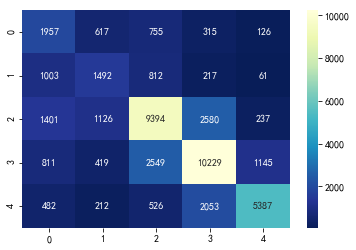

In [25]:
import pandas as pd
cm = pd.DataFrame(cm,columns=range(5),index=range(5))
sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True)

In [26]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=0.1, gamma=0.1).fit(X_train, y_train)

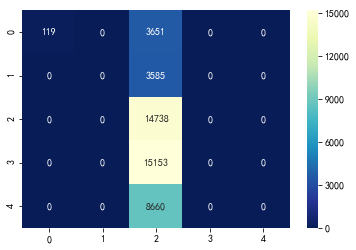

In [28]:
y_true = y_test
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_true,y_pred)

import pandas as pd
cm = pd.DataFrame(cm,columns=range(5),index=range(5))
sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True)

In [34]:
import numpy as np
# np.set_printoptions(threshold=np.inf)

import pylab as pl
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.io import wavfile
# download opensouce audio in
# http://www.voiptroubleshooter.com/open_speech/american.html

def getfft(sample_rate, signal):
    # 一、预处理(Preprocess)
    # 加载模型(load audio)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))

    # signal = signal[: int(3.5 * sample_rate)]  # read first 3.5s data for example.

    # n_frames = len(signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, signal)
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Original audio')
    # pl.show()

    # 预加重(Pre-Emphasis)
    # y(t) = x(t) - a * x(t - 1)
    pre_emphasis = 0.97  # usually 0.95 or 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[: -1]
    )

    # n_frames = len(emphasized_signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, emphasized_signal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Pre-Emphasis')
    # pl.show()

    # 分帧(Framing)
    # here, params set as follows:
    # frame_size = 0.025(s), it menas 8kHz signal has 0.025 * 8000 = 200 samples.
    # frame_stride = 0.01(s), 0.01 * 8000 = 80 samples.
    # overlap = 0.015(s), 0.015 * 8000 = 125 samples.
    frame_size, frame_stride, overlap = 0.025, 0.01, 0.015  # Convert from seconds to samples
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    singal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(
        float(np.abs(singal_length - frame_length)) / frame_step
    ))  # make sure we have at least 1 frame.

    pad_singal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_singal_length - singal_length))
    # pad singal to make sure that all frames have equal number of
    # samples without truncating any samples from the original signal.
    pad_singal = np.append(emphasized_signal, z)

    indices = np.tile(
        np.arange(0, frame_length), (num_frames, 1)
    ) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step),
        (frame_length, 1)
    ).T
    frames = pad_singal[indices.astype(np.int32, copy=False)]

    # 加窗(Window)
    # W(n, a) = (1 - a) - a * cos(2 * pi * n / (N - 1))
    # 0 <= n <= N, N is Window length, set a = 0.46 here.
    window = np.hamming(frame_length)
    # plt.plot(window)
    # plt.xlabel("Samples")
    # plt.ylabel("Amplitude")
    # plt.title("Hamming window")
    # plt.show()

    # n = np.arange(0, frame_length)
    # window = 0.54 - 0.46 * np.cos(2.0 * np.pi * n) / (frame_length - 1)  # Explicit Implementation
    frames *= window

    # n_frames = len(pad_singal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, pad_singal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Framing')
    # pl.show()

    # 二、傅里叶变换(FFT)和功率谱(Power Spectrum)
    # do an N-pont FFT on each frame to calculate the frequency spectrum,
    # also called STFT(Short-time FT), where N is typically 256 or 512,
    NFFT = 16384
    mag_frames = np.absolute((np.fft.rfft(frames, NFFT)))  # Magnitude of the FFT

    # compute the power spectrum using the following eqution:
    # P = |FFT(Xi)|^2 / N, Xi is ith frame of signal x.
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    return pow_frames

In [35]:
fft_ans = getfft(sample_rate, signal)

sample_rate:48000, len:12241920


In [36]:
fft_ans.shape

(51006, 8193)

In [ ]:
sns.heatmap(fft_ans)
plt.show()